In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import investpy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('bitcoin.csv')
print(df)

           Date     Open     High      Low    Close   Volume Currency
0    2020-06-01   9.4545  10.3018   9.4297  10.1893   796676      USD
1    2020-06-02  10.1907  10.2073   9.3473   9.5276  1058556      USD
2    2020-06-03   9.5270   9.6672   9.4217   9.6672   558116      USD
3    2020-06-04   9.6672   9.8644   9.4909   9.7944   593664      USD
4    2020-06-05   9.7940   9.8461   9.6287   9.6312   527054      USD
..          ...      ...      ...      ...      ...      ...      ...
726  2022-05-28  28.6201  29.1944  28.5372  29.0271    43871      USD
727  2022-05-29  29.0271  29.5565  28.8387  29.4652    36865      USD
728  2022-05-30  29.4652  32.1856  29.3072  31.7233   129556      USD
729  2022-05-31  31.7302  32.3775  31.2212  31.7934    86600      USD
730  2022-06-01  31.7931  31.9699  29.3966  29.7985   135091      USD

[731 rows x 7 columns]


In [3]:
# Process data
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("bitcoin_processed_8_2.csv")
df

,Date,Open,High,Low,Close,Volume,Currency,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,2020-06-21,9.3588,9.4112,9.2885,9.2964,335994,USD,0.1227,0.0624,9.395829,9.483050,9.570695,0.081565,0.231530
21,2020-06-22,9.2965,9.7519,9.2858,9.6837,523319,USD,0.4661,-0.3872,9.432729,9.476321,9.546619,0.136858,0.185749
22,2020-06-23,9.6839,9.7156,9.5818,9.6246,375494,USD,0.1338,0.0593,9.447171,9.466021,9.551238,0.152477,0.186457
23,2020-06-24,9.6246,9.6674,9.2230,9.3020,515777,USD,0.4444,0.3226,9.423943,9.424821,9.533848,0.161498,0.192047
24,2020-06-25,9.3008,9.3273,9.0226,9.2475,524453,USD,0.3047,0.0533,9.403857,9.422271,9.507805,0.174887,0.192030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-05-28,28.6201,29.1944,28.5372,29.0271,43871,USD,0.6572,-0.4070,29.343000,29.614214,29.865262,0.540794,1.205935
727,2022-05-29,29.0271,29.5565,28.8387,29.4652,36865,USD,0.7178,-0.4381,29.225657,29.482536,29.646462,0.361228,0.729537
728,2022-05-30,29.4652,32.1856,29.3072,31.7233,129556,USD,2.8784,-2.2581,29.601371,29.616414,29.724000,1.001290,0.855287
729,2022-05-31,31.7302,32.3775,31.2212,31.7934,86600,USD,1.1563,-0.0632,29.907757,29.713264,29.761424,1.301354,0.928330


In [4]:
pre_day = 30
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

142
(539, 30, 7) (539, 1) (142, 30, 7) (142, 1)


In [5]:
# Build model
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
model.save("bitcoin_lstm_8_2.h5")

Epoch 1/120
40/40 [==============================] - 12s 70ms/step - loss: 0.0422
Epoch 2/120
40/40 [==============================] - 3s 69ms/step - loss: 0.0159
Epoch 3/120
40/40 [==============================] - 3s 69ms/step - loss: 0.0137
Epoch 4/120
40/40 [==============================] - 3s 70ms/step - loss: 0.0146
Epoch 5/120
40/40 [==============================] - 3s 70ms/step - loss: 0.0127
Epoch 6/120
40/40 [==============================] - 3s 81ms/step - loss: 0.0113
Epoch 7/120
40/40 [==============================] - 3s 78ms/step - loss: 0.0097
Epoch 8/120
40/40 [==============================] - 3s 72ms/step - loss: 0.0101
Epoch 9/120
40/40 [==============================] - 3s 72ms/step - loss: 0.0084
Epoch 10/120
40/40 [==============================] - 3s 71ms/step - loss: 0.0082
Epoch 11/120
40/40 [==============================] - 3s 74ms/step - loss: 0.0061
Epoch 12/120
40/40 [==============================] - 3s 71ms/step - loss: 0.0060
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

5/5 [==============================] - 3s 26ms/step


(142, 1)


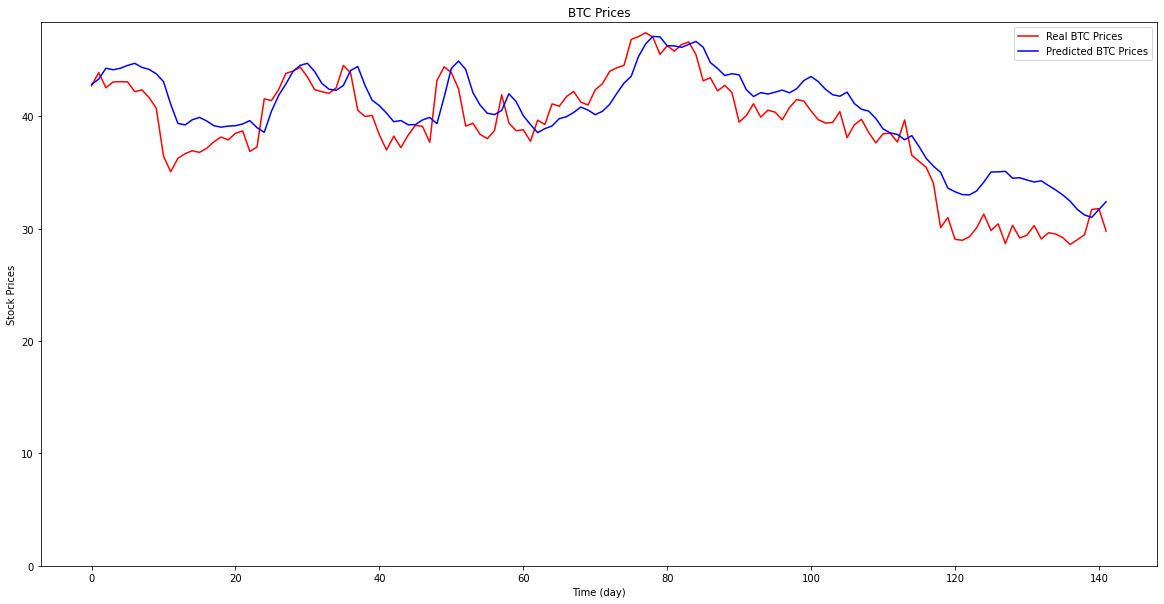

In [7]:
# Ploting the stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.figure(figsize=(20,10))
plt.plot(real_price, color="red", label=f"Real BTC Prices")
plt.plot(predict_price, color="blue", label=f"Predicted BTC Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [8]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 34ms/step
[[31.976362]]


In [9]:
mae = mean_absolute_error(real_price, predict_price)
mape = mean_absolute_percentage_error(real_price, predict_price)
mse = mean_squared_error(real_price, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.10
MAPE: 5.81%
MSE: 6.50
RMSE: 2.55
R2: 0.73
